In [1]:
!pip install -e ../../requirements.txt

import os
import numpy as np
import pandas as pd
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

# Matplotlib settings
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 150

!pip install mne==1.5.1
from mne import Epochs, find_events
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch

!pip install scikit-learn==1.3.2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from preprocessing import DataLoader

clear_output(wait=False)

In [2]:
PATH_DATA_RAW_FOLDER = os.path.join(os.getcwd(), '../../../Data')
PATH_DATA_RAW_TRIALS = [
    f'{PATH_DATA_RAW_FOLDER}/{f}' \
    for f in os.listdir(PATH_DATA_RAW_FOLDER) if f.endswith('.npy')
]
PATH_DATA_RAW_TRIALS.sort()

for i in range(10):
    print(PATH_DATA_RAW_TRIALS[i])

/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_001_Trial1.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_001_Trial2.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_002_Trial1.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_002_Trial2.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_002_Trial3.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_003_Trial1.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_003_Trial2.npy
/Users/briceappenzeller/Documents/PIE/PIE_2023/notebooks/exploration_pipeline_optimale/../../../Data/DATA_004_Trial1.npy
/Users/briceappenzeller/Document

In [3]:
# Let's save a function to preproc the data for a given subject, with a given stroke_side

def preproc(sample_id):
    loader = DataLoader(PATH_DATA_RAW_TRIALS[sample_id])
    stroke = loader.stroke_side

    # Select arm on opposite side of stroke side
    arm_side = 'G' if stroke == 'D' else 'G'
    eeg_data = loader.get_raws(side=arm_side)

    # Select corresponding electrods
    electrodes_R = [
        'Fz', 'F2', 'F4', 'F6', 'F8',
        'FCz','FC2','FC4','FC6','FT8', 
        'Cz', 'C2', 'C4', 'C6', 'T8',
        'CPz','CP2','CP4','CP6','TP8',
        'Pz', 'P2', 'P4', 'P6', 'P8',
    ]
    electrodes_L = [
        'Fz', 'F1', 'F3', 'F5', 'F7',
        'FCz','FC1','FC3','FC5','FT7', 
        'Cz', 'C1', 'C3', 'C5', 'T7',
        'CPz','CP1','CP3','CP5','TP7',
        'Pz', 'P1', 'P3', 'P5', 'P7',
    ]

    if stroke == 'G':
        mask_elec = electrodes_L
    else:
        mask_elec = electrodes_R
    mask = mask_elec + ['movement']
    data = eeg_data.copy().pick_channels(mask)

    return loader, data

In [4]:
def extract_epochs(raws, 
                   fmin=8, 
                   fmax=30, 
                   tmin=-1.5, 
                   tmax=+1.5):
    # Apply band-pass filter 
    raws.filter(fmin, fmax, fir_design='firwin', skip_by_annotation='edge')
    # Recup events 
    events = find_events(raws, stim_channel='movement')
    # Apply epoching around events
    epochs = Epochs(raws, events, event_id=None, tmin=tmin, tmax=tmax, preload=True)
    labels = epochs.events[:, -1] - 1

    return epochs, labels

In [5]:
def extract_windows(epochs, w_size=1., w_step=.1):
    # Define windows size and step in samples
    w_size_samp = int(w_size * epochs.info['sfreq'])
    w_step_samp = int(w_step * epochs.info['sfreq'])
    w_start = np.arange(0, epochs.get_data().shape[2] - w_size_samp, w_step_samp)
    w_event = epochs.get_data().shape[2] // 2

    # Extract windows and targets
    windows = []
    targets = []
    for j in range(epochs.get_data().shape[0]):
        windows_epoch = []
        targets_epoch = []
        for i in w_start:
            windows_epoch.append(epochs.get_data()[j, :, i:i + w_size_samp])
            if i <= w_event <= i + w_size_samp: # A VOIR POUR CHANGER ÇA : si la fenêtre commence juste avant le mouvement on va labéliser ça en 1 alors que l'intention sera déjà sûrement passé et faut que l'instant d'intention soit cohérent avec la taille de windows
                targets_epoch.append(1)
            else:
                targets_epoch.append(0)
        
        windows.append(np.array(windows_epoch))
        targets.append(np.array(targets_epoch))
    
    windows = np.concatenate(windows)
    targets = np.concatenate(targets)

    return windows, targets

In [6]:
sample_id = 0

w_size = 1.
w_step = .1
fmin=8
fmax=30

loader_sample_id, data_sample_id = preproc(sample_id)
epochs, labels = extract_epochs(data_sample_id, fmin=fmin, fmax=fmax) 
windows, targets = extract_windows(epochs, w_size=w_size, w_step=w_step)
windows_without_mvt = windows[:,0:-1,:]

print(windows.shape)
print(windows_without_mvt.shape)
print(targets.shape)
print("Class distribution:", np.unique(targets, return_counts=True))
print("Class imbalance:   ", np.unique(targets, return_counts=True)[1][0] / np.unique(targets, return_counts=True)[1].sum())

(399, 26, 1024)
(399, 25, 1024)
(399,)
Class distribution: (array([0, 1]), array([209, 190]))
Class imbalance:    0.5238095238095238


In [7]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier()

pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('RandomForestClassifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(windows_without_mvt, targets, test_size=0.2, random_state=42, shuffle=False)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5125


In [9]:
max_sample_size = data_sample_id.get_data().shape[1]
idx_begin = 0
idx_end = 50000

data_cleaned = data_sample_id.filter(fmin, fmax, fir_design='firwin', skip_by_annotation='edge')

eeg_freq = loader_sample_id.eeg_freq
w_size_idx = int(w_size * eeg_freq)
w_step_idx = int(w_step * eeg_freq)
print(f"windows size: {w_size_idx}\nwindows step: {w_step_idx}")

windows_start = np.arange(idx_begin, idx_end - w_size_idx, w_step_idx)
windows_indices = []
raw_windows = []

for i, window_start in enumerate(windows_start):
    raw_windows.append(np.array(data_cleaned.get_data()[0:25,window_start:window_start+w_size_idx]))
    windows_indices.append([window_start, window_start+w_size_idx])
raw_windows = np.array(raw_windows)
print(f"shape of raw_windows {raw_windows.shape}")

windows size: 1024
windows step: 102
shape of raw_windows (481, 25, 1024)


In [10]:
def get_movements(loader):
    
    # Get indices where there is a movement
    stroke = loader_sample_id.stroke_side
    if stroke == 'G':
        movements_indices = loader_sample_id.movement_index_right_arm.copy()
    else:
        movements_indices = loader_sample_id.movement_index_left_arm.copy()
        
    # Shift the indices so it corresponds with eeg frequency
    cinematic_freq = loader_sample_id.cinematic_freq
    eeg_freq = loader_sample_id.eeg_freq
    for i in range(len(movements_indices)):
        movements_indices[i] = int(movements_indices[i] * eeg_freq/cinematic_freq)
    
    # Construct an array where the dimension is the time ; 1: movement, 0: no movement
    movements = np.zeros(movements_indices[-1]+1)
    for movement_idx in movements_indices:
        movements[movement_idx] = 1
        
    return movements

all_movements = get_movements(loader_sample_id)
movements = all_movements[idx_begin:idx_end]
print(f"Number of no-movements: {np.count_nonzero(movements == 0)}\nNumber of movements: {np.count_nonzero(movements == 1)}")

Number of no-movements: 49729
Number of movements: 271


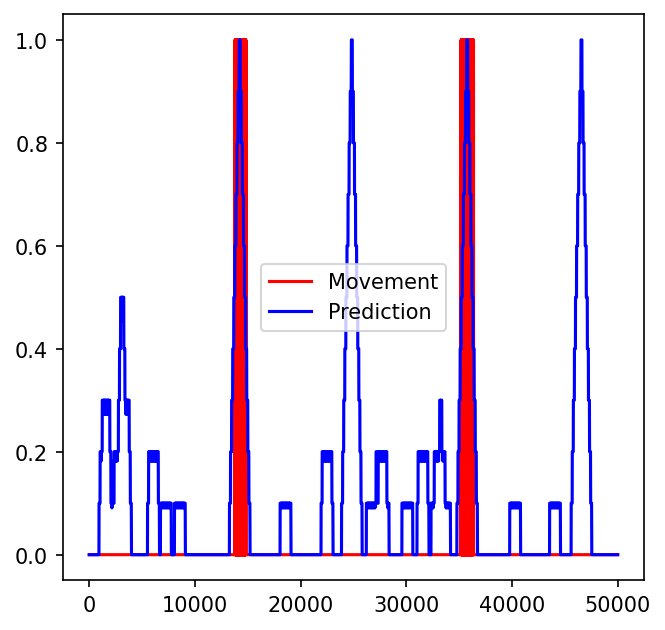

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
def plot_results(pipeline, windows, windows_indices, movements):
    """
    windows_indices: indices permettant de savoir où est la window par rapport au mouvement
    windows_indices[i] = [i_start, i_end]
    """
    counts = np.zeros(len(movements))
    counts_nb_windows = np.zeros(len(movements))
    predictions = pipeline.predict(windows)
    for i, prediction in enumerate(predictions):
        if prediction == 1:
            counts[windows_indices[i][0]:windows_indices[i][1]] += 1
        counts_nb_windows[windows_indices[i][0]:windows_indices[i][1]] += 1
            
    normalized_counts = [counts[i] / counts_nb_windows[i] if counts_nb_windows[i] != 0 else 0 for i in range(len(counts))]      
    x = range(len(movements)) 
    plt.plot(x, movements, color='red')
    plt.plot(x, normalized_counts, color='blue')
    plt.legend(["Movement", "Prediction"])
    plt.show()
    
    return counts

plot_results(pipeline, raw_windows, windows_indices, movements)